### Ensemble Extras

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.inspection import plot_partial_dependence, partial_dependence

In [2]:
cali = fetch_california_housing()

In [3]:
X, y = pd.DataFrame(cali.data, columns = cali.feature_names), cali.target

In [4]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
gboost = GradientBoostingRegressor()

In [7]:
gboost.fit(X_train, y_train)

GradientBoostingRegressor()

In [8]:
gboost.score(X_test, y_test)

0.7871495354364801

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [10]:
#baseline model
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

-2.69261017300515e-05

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6023730001646572

### Grid Search Hyperparameters

In [12]:
gboost2 = GradientBoostingRegressor()
params = {'loss': ['ls', 'huber'],
         'learning_rate': [.1, .01],
         'n_estimators': [25, 50, 100]}

In [13]:
gboost_grid = GridSearchCV(gboost2, param_grid=params)

In [15]:
gboost_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.01], 'loss': ['ls', 'huber'],
                         'n_estimators': [25, 50, 100]})

In [16]:
gboost_grid.score(X_test, y_test)

0.7871495354364801

In [17]:
importances = gboost_grid.best_estimator_.feature_importances_
features = cali.feature_names
import_df = pd.DataFrame({'importance': importances, 'features': features})

In [18]:
import_df

,importance,features
0,0.604688,MedInc
1,0.034471,HouseAge
2,0.022785,AveRooms
3,0.003742,AveBedrms
4,0.003689,Population
5,0.124641,AveOccup
6,0.092108,Latitude
7,0.113875,Longitude


In [25]:
import_df.sum()

importance                                                    1
features      PopulationAveBedrmsAveRoomsHouseAgeLatitudeLon...
dtype: object

<BarContainer object of 8 artists>

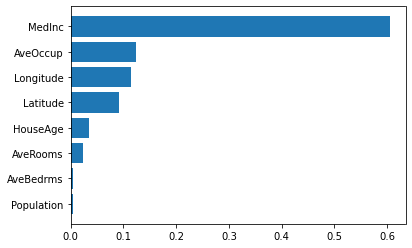

In [24]:
import_df.sort_values(by = 'importance', inplace = True)
plt.barh(import_df['features'], width = import_df['importance'])

In [38]:
gbres = pd.DataFrame(gboost_grid.cv_results_)['mean_fit_time']

In [29]:
histreg = HistGradientBoostingRegressor()

In [30]:
params = {'loss': ['least_squares', 'poisson'],
         'learning_rate': [0.1, 0.01, 0.8],
         'max_iter': [50, 100, 200]}

In [31]:
histgrid = GridSearchCV(histreg, param_grid=params)

In [32]:
histgrid.fit(X_train, y_train)

GridSearchCV(estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.01, 0.8],
                         'loss': ['least_squares', 'poisson'],
                         'max_iter': [50, 100, 200]})

In [37]:
hres = pd.DataFrame(histgrid.cv_results_)['mean_fit_time']

In [35]:
from scipy import stats

In [40]:
stats.mannwhitneyu(gbres, hres)

MannwhitneyuResult(statistic=68.0, pvalue=0.047245565935051935)

In [41]:
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']

In [42]:
est = histgrid.best_estimator_

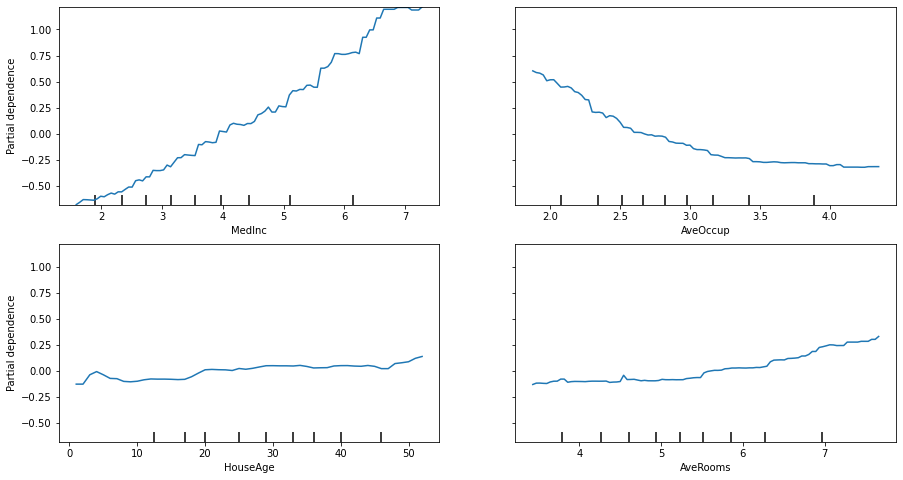

In [45]:
fig, ax = plt.subplots(figsize = (15, 8))
plot_partial_dependence(est, X_train, features, n_cols=2, ax = ax)

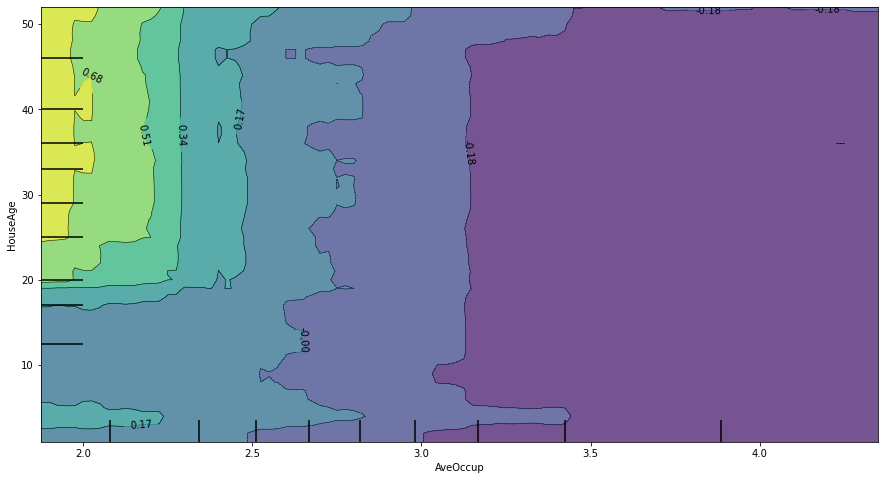

In [47]:
fig, ax = plt.subplots(figsize = (15, 8))
plot_partial_dependence(est, X_train, [('AveOccup', 'HouseAge')], ax = ax)

In [48]:
from mpl_toolkits.mplot3d import Axes3D

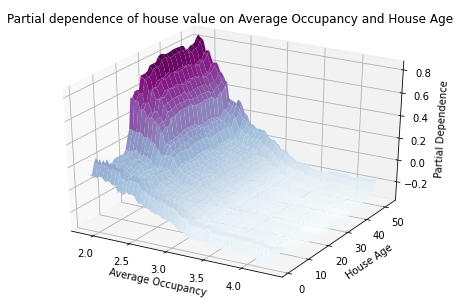

In [54]:
fig = plt.figure()

features = ('AveOccup', 'HouseAge')

pdp, axes = partial_dependence(est, X_train, features)

X, Y = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)

ax.plot_surface(X, Y, Z, cmap = plt.cm.BuPu)
ax.set_xlabel('Average Occupancy')
ax.set_ylabel('House Age')
ax.set_zlabel('Partial Dependence')
plt.suptitle('Partial dependence of house value on Average Occupancy and House Age');

In [57]:
ads = pd.read_csv('ads.csv', index_col = 0)

In [58]:
ads.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


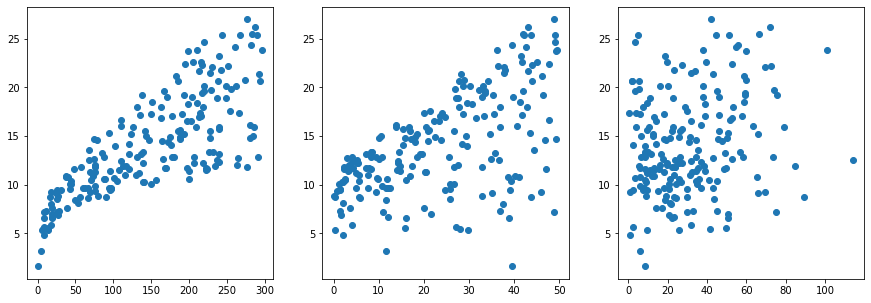

In [61]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(ads.TV, ads.sales)
ax[1].scatter(ads.radio, ads.sales)
ax[2].scatter(ads.newspaper, ads.sales)

In [62]:
import seaborn as sns

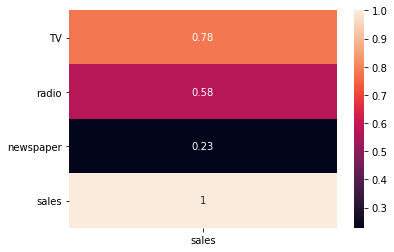

In [64]:
sns.heatmap(ads.corr()[['sales']], annot = True)

In [65]:
ads['interaction'] = ads.TV*ads.radio

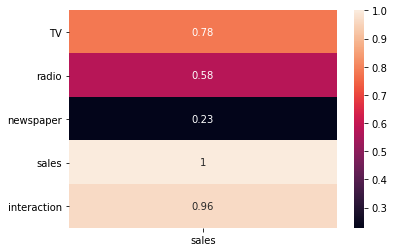

In [66]:
sns.heatmap(ads.corr()[['sales']], annot = True)

In [67]:
histbooster3 = HistGradientBoostingRegressor()

In [68]:
histbooster3.fit(ads.drop('sales', axis = 1), ads.sales)

HistGradientBoostingRegressor()

In [72]:
from ipywidgets import interact
import ipywidgets as widgets

In [73]:
def pdep_plotter(v, w):
    fig = plt.figure()

    features = ('TV', 'radio')

    pdp, axes = partial_dependence(histbooster3, ads.drop('sales', axis = 1), features)

    X, Y = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].T
    ax = Axes3D(fig)
    ax.view_init(v, w)
    ax.plot_surface(X, Y, Z, cmap = plt.cm.BuPu)
    ax.set_xlabel('TV')
    ax.set_ylabel('radio')
    ax.set_zlabel('Partial Dependence')
    plt.suptitle('Partial dependence of sales on TV and Radio');



In [75]:
interact(pdep_plotter, v = widgets.IntSlider(start = 0, stop = 360, step = 1),
            w = widgets.IntSlider(start = 0, stop = 360, step = 1))

interactive(children=(IntSlider(value=0, description='v'), IntSlider(value=0, description='w'), Output()), _do…

<function __main__.pdep_plotter(v, w)>